## Setup

### Package Imports and Options

In [1]:
from os import getcwd
import glob
from pprint import pprint

import pandas as pd
import numpy as np
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# note I ran into an issue import tensorflow with Python 3.7. Solved via:
# https://github.com/tensorflow/tensorflow/issues/20690
import tensorflow as tf

# I also ran into and issue importing edward with tensorflow > 1.5. Solved via:
# https://github.com/blei-lab/edward/issues/893
# ran into another edward - TF compatibility issue. Tried solving via:
# https://github.com/blei-lab/edward/issues/895 — this solution didn't work however (still solving)
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import edward as ed

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

### Load Data

In [3]:
dic = pd.read_excel('data/LCDataDictionary.xlsx')

In [4]:
csv_files = glob.glob(f'{getcwd()}/data/*.csv')
df_raw = pd.concat((pd.read_csv(f, header=1, low_memory=False) for f in csv_files))

In [5]:
df = df_raw

In [15]:
df.term.value_counts()

 36 months    1432001
 60 months    572061 
Name: term, dtype: int64

In [67]:
df_36 = df.loc[df.term == ' 36 months',:]
df_60 = df.loc[df.term == ' 60 months',:]

## Building transitions month per month

**Step 1:** We need to find month information to know when was each data point created.

In [84]:
samples = df_36.sample(10) # sample 10 points from the data to explore

In [242]:
good_columns = ['loan_status',
                'loan_amnt',
                'issue_d',
                'term',
                'last_pymnt_d',
                'last_pymnt_amnt',
                'next_pymnt_d',
                'installment',
                # 'mths_since_last_delinq',
                # 'mths_since_last_record',
                'total_pymnt',
                'last_credit_pull_d',
                'delinq_amnt',
                'chargeoff_within_12_mths'] 

In [243]:
samples[good_columns]

,loan_status,loan_amnt,issue_d,term,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,installment,total_pymnt,last_credit_pull_d,delinq_amnt,chargeoff_within_12_mths
10421,Current,5000.0,Jun-2016,36 months,Oct-2018,185.80,Nov-2018,185.80,5191.290000,Oct-2018,0.0,0.0
313598,Fully Paid,4000.0,Apr-2015,36 months,Apr-2018,133.42,NaN,133.42,4800.399120,May-2018,0.0,0.0
84315,Fully Paid,4800.0,Aug-2014,36 months,Sep-2017,172.41,NaN,172.50,6213.170018,Sep-2017,0.0,0.0
64455,Charged Off,5000.0,Feb-2018,36 months,Apr-2018,180.92,NaN,180.92,356.820000,Oct-2018,0.0,0.0
21047,Current,28000.0,Dec-2017,36 months,Oct-2018,938.32,Nov-2018,938.32,9363.570000,Oct-2018,0.0,0.0
66998,Current,35000.0,May-2017,36 months,Oct-2018,1247.68,Nov-2018,1247.68,21177.520000,Oct-2018,0.0,0.0
355324,Fully Paid,35000.0,Mar-2015,36 months,Sep-2015,31591.44,NaN,1223.77,37649.580000,May-2018,0.0,0.0
106917,Current,7800.0,Jan-2018,36 months,Oct-2018,274.31,Nov-2018,274.31,2461.850000,Oct-2018,0.0,0.0
19732,Current,3200.0,Mar-2017,36 months,Oct-2018,108.58,Nov-2018,108.58,2064.410000,Oct-2018,0.0,0.0
237590,Fully Paid,5000.0,Jul-2015,36 months,Aug-2015,5031.78,NaN,156.43,5029.590000,Jul-2015,0.0,0.0


In [244]:
df2 = df[good_columns]

In [162]:
df2.isnull().mean()

loan_status                 0.000014
loan_amnt                   0.000014
issue_d                     0.000014
last_pymnt_d                0.001074
last_pymnt_amnt             0.000014
next_pymnt_d                0.579682
installment                 0.000014
total_pymnt                 0.000014
last_credit_pull_d          0.000049
delinq_amnt                 0.000029
chargeoff_within_12_mths    0.000087
dtype: float64

In [245]:
for c in ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']:
    df2[c] = pd.to_datetime(df2[c])

/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [246]:
import pickle

In [247]:
with open('df_with_time.pkl', 'wb') as f:
    pickle.dump(df2, f)

In [165]:
df2.issue_d.min(), df2.issue_d.max()

(Timestamp('2007-06-01 00:00:00'), Timestamp('2018-06-01 00:00:00'))

In [155]:
df2.issue_d.max() - df2.issue_d.min()

Timedelta('4018 days 00:00:00')

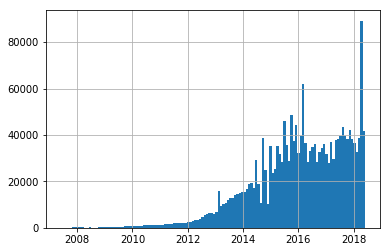

In [187]:
df2.issue_d.hist(bins=130);

In [166]:
df2.head()

,loan_status,loan_amnt,issue_d,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,installment,total_pymnt,last_credit_pull_d,delinq_amnt,chargeoff_within_12_mths
0,Fully Paid,5000.0,2011-12-01,2015-01-01,171.62,NaT,162.87,5863.155187,2018-10-01,0.0,0.0
1,Charged Off,2500.0,2011-12-01,2013-04-01,119.66,NaT,59.83,1014.530000,2016-10-01,0.0,0.0
2,Fully Paid,2400.0,2011-12-01,2014-06-01,649.91,NaT,84.33,3005.666844,2017-06-01,0.0,0.0
3,Fully Paid,10000.0,2011-12-01,2015-01-01,357.48,NaT,339.31,12231.890000,2016-04-01,0.0,0.0
4,Fully Paid,3000.0,2011-12-01,2017-01-01,67.30,NaT,67.79,4066.908161,2018-04-01,0.0,0.0


In [168]:
df2.last_pymnt_d.min(), df2.last_pymnt_d.max()

(Timestamp('2007-12-01 00:00:00'), Timestamp('2018-10-01 00:00:00'))

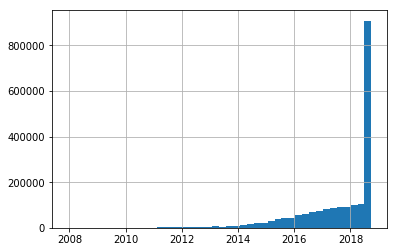

In [174]:
df2.last_pymnt_d.hist(bins=44); # one bin per quarter

In [214]:
(df2.last_pymnt_d.dropna().value_counts()/df2.last_pymnt_d.dropna().shape[0]).head()

2018-10-01    0.413900
2018-08-01    0.020052
2018-09-01    0.019437
2018-03-01    0.019116
2018-07-01    0.018499
Name: last_pymnt_d, dtype: float64

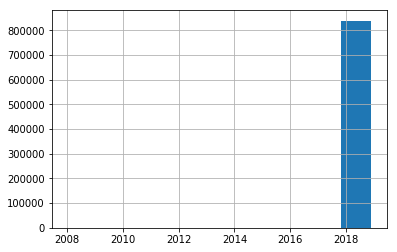

In [209]:
df2.next_pymnt_d.dropna().hist();

In [213]:
(df2.next_pymnt_d.dropna().value_counts()/df2.next_pymnt_d.dropna().shape[0]).head()

2018-11-01    0.996414
2018-10-01    0.000173
2018-12-01    0.000142
2011-03-01    0.000127
2011-04-01    0.000120
Name: next_pymnt_d, dtype: float64

In [196]:
df2.head()

,loan_status,loan_amnt,issue_d,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,installment,total_pymnt,last_credit_pull_d,delinq_amnt,chargeoff_within_12_mths
0,Fully Paid,5000.0,2011-12-01,2015-01-01,171.62,NaT,162.87,5863.155187,2018-10-01,0.0,0.0
1,Charged Off,2500.0,2011-12-01,2013-04-01,119.66,NaT,59.83,1014.530000,2016-10-01,0.0,0.0
2,Fully Paid,2400.0,2011-12-01,2014-06-01,649.91,NaT,84.33,3005.666844,2017-06-01,0.0,0.0
3,Fully Paid,10000.0,2011-12-01,2015-01-01,357.48,NaT,339.31,12231.890000,2016-04-01,0.0,0.0
4,Fully Paid,3000.0,2011-12-01,2017-01-01,67.30,NaT,67.79,4066.908161,2018-04-01,0.0,0.0


In [194]:
(df2[['last_pymnt_d', 'next_pymnt_d']] >= pd.Timestamp('2018-10-01 00:00:00')).head()

,last_pymnt_d,next_pymnt_d
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [192]:
(df2[['last_pymnt_d', 'next_pymnt_d']] >= pd.Timestamp('2018-10-01 00:00:00')).mean()

last_pymnt_d    0.414530
next_pymnt_d    0.998625
dtype: float64

In [182]:
df2.next_pymnt_d.max()

Timestamp('2018-12-01 00:00:00')

In [158]:
df2['loan_status'].value_counts()/df2.shape[0]

Fully Paid                                             0.463105
Current                                                0.398671
Charged Off                                            0.116563
Late (31-120 days)                                     0.011490
In Grace Period                                        0.005963
Late (16-30 days)                                      0.002812
Does not meet the credit policy. Status:Fully Paid     0.000992
Does not meet the credit policy. Status:Charged Off    0.000380
Default                                                0.000011
Name: loan_status, dtype: float64

**Important**: we have the status **today** of any loan that has ever existed on LC. We don't have any previous status.

Q3 ended sept 30, so if we look at the difference between the start date and oct 1, we know how old is each data point:

In [249]:
df2['age_of_loan'] = pd.Timestamp('2018-10-01 00:00:00') - df2.issue_d

/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


How old are the loans:

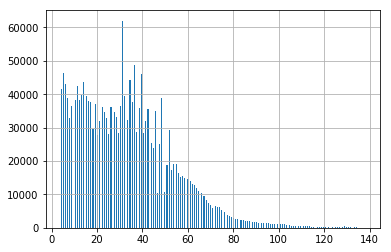

In [250]:
(df2['age_of_loan']/pd.Timedelta(days=30)).hist(bins='auto');

How old are the 36 month term loans:

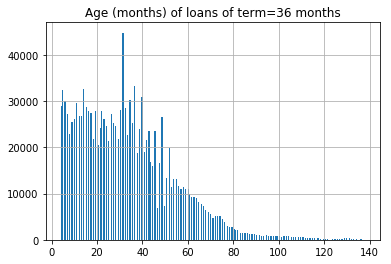

In [254]:
(df2.loc[df2['term'] == ' 36 months', 'age_of_loan']/pd.Timedelta(days=30)).hist(bins='auto');
plt.title('Age (months) of loans of term=36 months');

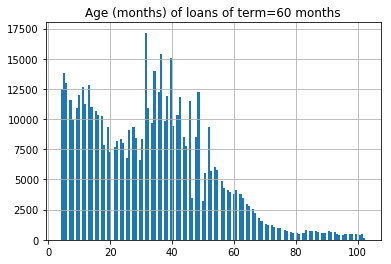

In [255]:
(df2.loc[df2['term'] == ' 60 months', 'age_of_loan']/pd.Timedelta(days=30)).hist(bins='auto');
plt.title('Age (months) of loans of term=60 months');

Adjust loans that are already finished:

In [ ]:
df2['age_of_loan'] >= pd.Timedelta(days=1095)

36 months = 1095 days. Adjust accordingly:

In [261]:
df2.loc[(df2['term'] == ' 36 months') & (df2['age_of_loan'] >= pd.Timedelta(days=1095)), 'age_of_loan'] = pd.Timedelta(days=1095)

/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Same for 60 months = 1825 days:

In [262]:
df2.loc[(df2['term'] == ' 60 months') & (df2['age_of_loan'] >= pd.Timedelta(days=1825)), 'age_of_loan'] = pd.Timedelta(days=1825)

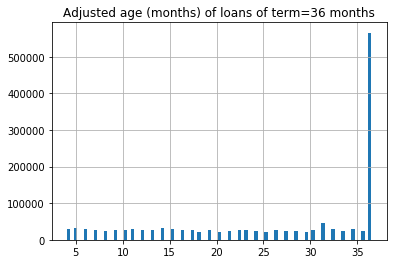

In [263]:
(df2.loc[df2['term'] == ' 36 months', 'age_of_loan']/pd.Timedelta(days=30)).hist(bins='auto');
plt.title('Adjusted age (months) of loans of term=36 months');

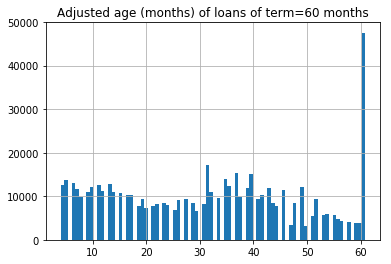

In [264]:
(df2.loc[df2['term'] == ' 60 months', 'age_of_loan']/pd.Timedelta(days=30)).hist(bins='auto');
plt.title('Adjusted age (months) of loans of term=60 months');